In [98]:
import sklearn
import optuna
from scipy.stats import bootstrap as boot
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_theme()

c:\Users\unstr\AppData\Local\R-MINI~1\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('arctic1008_new.csv')
df

,Unnamed: 0,City,P_avg_per_m_sec,Population,P_avg_per_m_new,Expl_t_avg_sec,month,dummy_space,dummy_time,year,t,Reg_russian,Reg,Federal_district,lat,lon,city_id,month_dt
0,0,Абаза,39990,12272,NaN,NaN,4,0,0,2022,40,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-04-01
1,1,Абаза,29263,12272,NaN,NaN,5,0,0,2022,41,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-05-01
2,2,Абаза,36952,12272,NaN,7 д 1 ч,6,0,0,2022,42,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-06-01
3,3,Абаза,30629,12272,NaN,124 д,7,0,0,2022,43,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-07-01
4,4,Абаза,22034,12272,NaN,25 д 9 ч,8,0,0,2022,44,Республика Хакасия,respublika-khakasiya,Сибирский,52.65000,90.08333,137,2022-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11903,11903,Лабытнанги,110075,25501,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,66.65806,66.38389,471,2024-05-01
11904,11904,Муравленко,110122,29233,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,63.79444,74.49722,753,2024-05-01
11905,11905,Новый Уренгой,186632,107251,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,66.08472,76.67889,104,2024-05-01
11906,11906,Ноябрьск,143567,100188,NaN,NaN,5,1,0,2024,65,Ямало-Ненецкий автономный округ,yamalo-nenetskiy-avtonomniy-okrug,Уральский,63.20167,75.45167,801,2024-05-01


In [3]:
control_cities = list(set(list(df.query('dummy_space== 0')['city_id'])))
len(control_cities)


435

In [4]:
import random
random.seed(37)
group_of_items = control_cities  
num_to_select = 135                           
list_of_random_items = random.sample(group_of_items, num_to_select)
df['placebo_flg'] = df['city_id'].apply(lambda x: int(x in list_of_random_items))

In [69]:
df['dummy_space'].sum()

598

In [91]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from datetime import datetime

def synth_ci(df
    , lasso_alpha:float
    , id_name = 'city_id' 
    , t_name = 'month_dt'
    , dummy_space_name = 'dummy_space' 
    , validation_start_dt = '2023-06-01'
    , y_name = 'P_avg_per_m_sec'
    , trend = False
    , dummies = True
    , optuna_penalty = 0.1
    , optuna_thresh = 0.05
    ):
    
    df['city_id'] = df['city_id'].astype(str)

    

    def sc(city_id_list:list):
        '''Функция, которая принимает на вход DataFrame с id городов 
        и выдаёт временной ряд среднего эффекта воздействия'''
        sub_df = df[df[id_name].apply(lambda x: x in city_id_list)]
        treatment_cities = list(set(list(sub_df.query(dummy_space_name+'== 1')[id_name])))
        placebo_cities = list(set(list(sub_df.query('placebo_flg == 1')[id_name])))
        tmps =[]
        cities_list = treatment_cities+placebo_cities

        #Идём по городам воздействия и плацебо
        if len(cities_list) == 0:
            return np.nan
        for city in cities_list:
            #Берём один город плацебо|воздействия и все контрольные
            tmp = sub_df[(sub_df[id_name] == city) | (sub_df[dummy_space_name] == 0) & (sub_df['placebo_flg'] == 0)]
            #Вытягиваем в столбик и потом конкатенируем
            tmp = tmp.pivot(index = t_name, columns = id_name, values = y_name).reset_index()
            #Добавляем фиктивную переменную города для сдвига
            tmp['tr_city_id'] = city
            tmp['tr_city'] = tmp[city]
            tmp['placebo_flg'] = 1 if city in placebo_cities else 0
            tmp.drop(columns = city, inplace = True)
            tmps += [tmp]        

        tmp = pd.concat(tmps)
        
        if trend:
            #Разница в датах считается в днях, потому что по-другому я не смог
            tmp['t'] = tmp[t_name].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))-datetime.strptime('2022-04-01', '%Y-%m-%d')
            tmp['t'] = tmp['t'].apply(lambda x: abs(x).days)

        if dummies:
            #Делаю фиктивные переменные городов воздействия/плацебо 
            enc = OneHotEncoder(sparse_output=False, drop='first')
            enc_transformed = enc.fit_transform(tmp[['tr_city_id']])
            enc_df = pd.DataFrame(columns=enc.get_feature_names_out(), data=enc_transformed)
            tmp = pd.concat([tmp.reset_index(drop=True), enc_df.reset_index(drop=True)], axis=1)      

        #Обучаем регрессию на претренде
        train = tmp.loc[tmp[t_name] < validation_start_dt]
        val = tmp.loc[(tmp[t_name] >= validation_start_dt)&(tmp[t_name] <'2023-12-01')]
        scaler = StandardScaler()
        scaler.fit(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg']))

        # def objective(trial):
        #     lasso_alpha = 
        #     regr = Lasso()
        #     return val_r2 - optuna_penalty*abs(val_r2-train_r2) if abs(val_r2-train_r2) >=optuna_thresh else val_r2


        lr = Lasso(alpha=lasso_alpha)
        lr.fit(scaler.transform(train.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])), train['tr_city'])
            #Записываем в результат разницу между истинным значением и предиктом
        res = pd.DataFrame({'y_true':tmp['tr_city'], 'y_predict': lr.predict(scaler.transform(tmp.drop(columns = ['tr_city', t_name, 'tr_city_id', 'placebo_flg'])))
                            , t_name:tmp[t_name], 'city_id':tmp['tr_city_id'], 'placebo_flg': tmp['placebo_flg']})
        res['diff'] = res['y_true'] - res['y_predict']
        return res
    
    cities_list = list(set(list(df[id_name])))
    #Обучаем модель на всех городах
    res1 = sc(cities_list)
    #Смотрим распределение плацебо-группы
    res2 = res1.query('placebo_flg == 1').pivot(index='month_dt', columns='city_id', values='diff').reset_index()
    #Для плацебо считаем квантили, соответствующие уровню значимости alpha
    res2['lower2.5'], res2['upper97.5'], res2['upper95'], res2['upper90'] = np.quantile(res2.drop(columns='month_dt'),0.025, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.975, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.95, axis = 1), np.quantile(res2.drop(columns='month_dt'),0.9, axis = 1)
    res1 = res1.query('placebo_flg == 0')
    res1 = res1.groupby('month_dt', as_index=False).agg({'diff':'mean'})
    fig, ax = plt.subplots()
    # sns.lineplot(res1, x = 'month_dt', y = 'diff', hue = 'city_id', legend=False)#, ax=ax)
    plt.plot(res1['month_dt'], res1['diff'], color = 'orange')
    plt.xticks(rotation =90)
    plt.plot(res2['month_dt'], res2['lower2.5'], color = 'b')
    plt.plot(res2['month_dt'], res2['upper97.5'], color = 'b')
    plt.plot(res2['month_dt'], res2['upper95'], color = 'k' )
    plt.plot(res2['month_dt'], res2['upper90'], color = 'k')
    plt.vlines(x = ['2023-12-01', validation_start_dt], ymin = res2['lower2.5'].min(), ymax = res2['upper97.5'].max(), colors='k', linestyles='--')

    return res1

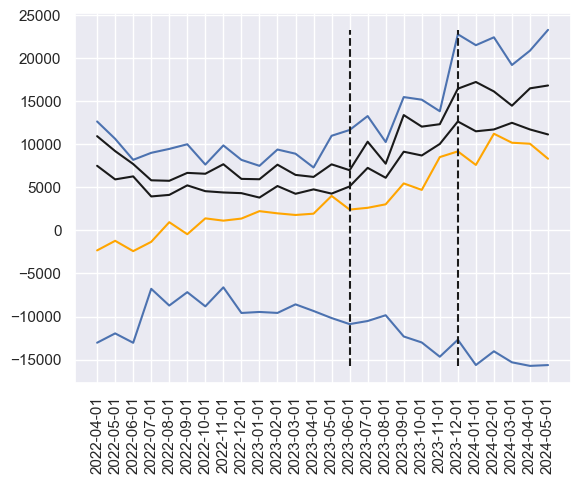

In [96]:
data = synth_ci(df, lasso_alpha= 10, validation_start_dt='2023-06-01')#.pivot(index='month_dt', columns='city_id', values='diff').reset_index()


<Axes: xlabel='month_dt', ylabel='diff'>

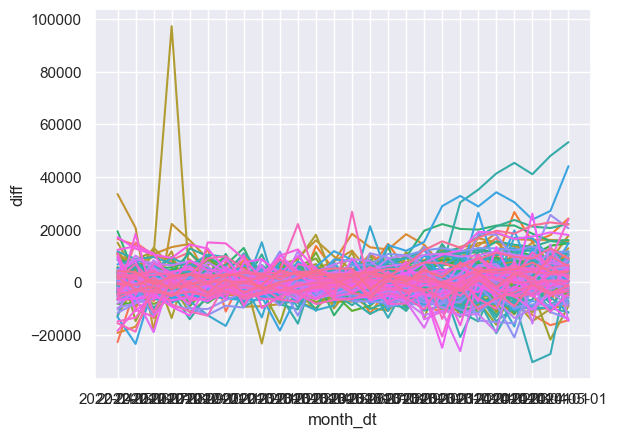

In [18]:
sns.lineplot(data, x = 'month_dt', y = 'diff', hue = 'city_id', legend=False)

<Axes: xlabel='month_dt', ylabel='diff'>

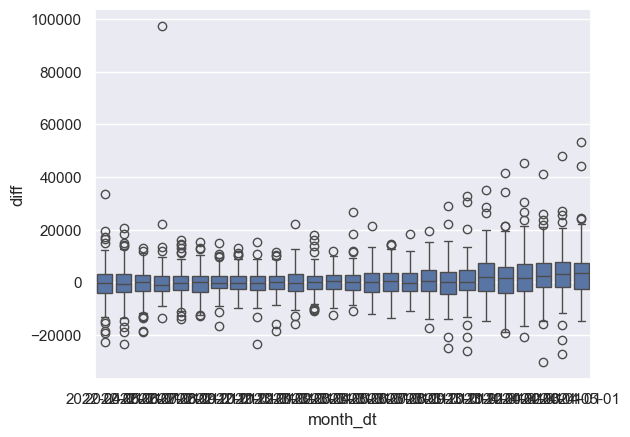

In [19]:
sns.boxplot(data, x = 'month_dt', y = 'diff', legend=False)


In [29]:
t_treatment= '2023-06-01'
data2 = synth_ci(df, alpha = 200, t_treatment= t_treatment).pivot(index='month_dt', columns='city_id', values='diff').reset_index()
data2

city_id,month_dt,108,11,114,122,124,137,143,154,161,...,923,928,934,936,938,942,945,95,950,97
0,2022-04-01,-4034.450466,1721.652108,-3342.896939,-3984.682653,-4766.182653,7871.960204,3568.294965,33644.580679,-7079.825511,...,18148.937804,-5660.896957,-631.896958,965.294946,3608.960185,-15842.182672,-15244.276483,101.866374,2847.549534,3710.223517
1,2022-05-01,-6664.016779,2703.085795,-3316.463252,-1568.248966,1417.251033,-2659.606110,1312.728651,20810.014365,-6678.391824,...,402.371491,-3451.463271,-8748.463271,-598.271367,-1613.606128,-19042.748986,-12860.842796,-84.699939,1894.983221,7838.657204
2,2022-06-01,3464.682742,3362.785317,-1313.763730,-674.549445,-2195.049445,5126.093412,1655.428173,-18590.286113,-5038.692303,...,5718.071012,-5545.763749,1213.236251,-1294.571845,-9442.906607,-327.049464,-1112.143274,-1582.000417,4426.682742,6207.356725
3,2022-07-01,9203.601720,1851.704295,-2053.844752,-4986.630467,-2067.130467,-2508.987610,1331.347151,22041.632865,-4001.773325,...,2376.989990,-1163.844771,-3554.844771,617.347133,250.012371,-8953.130486,297.775704,407.918561,-899.398280,5284.275703
4,2022-08-01,-9468.757584,2325.344991,-3652.204056,-2443.989771,750.510229,-10486.346914,2348.987847,15934.273561,-2885.132629,...,9807.630686,1661.795925,848.795925,653.987829,-10114.346933,-11485.489790,-2693.583600,3071.559257,172.242416,7100.916399
5,2022-09-01,-2043.133788,2345.968786,-4739.580261,9204.634025,-6206.865975,-13207.723118,1313.611643,9034.897357,-6695.508833,...,3376.254482,-7836.580279,1315.419721,1053.611624,-4708.723137,-12963.865994,4694.040195,613.183052,2934.866212,5213.540195
6,2022-10-01,325.256663,1645.359238,5420.810191,708.024477,-5186.475524,-9840.332667,1863.002094,2564.287808,-2171.118381,...,5113.644934,800.810172,-3603.189828,1386.002076,-2286.332685,-659.475543,-966.569353,1164.573504,-2783.743337,-325.069353
7,2022-11-01,-5794.183992,3795.918582,-9025.630465,374.583821,-1178.916179,-10165.773322,1747.561438,-9022.152847,-1275.559037,...,11987.204278,-2963.630483,-6178.630484,1807.561420,-3106.773341,-6456.916198,-753.010009,2070.132848,1845.816008,-1124.510009
8,2022-12-01,1324.112395,2848.214969,5545.665922,-1070.119792,-2946.619792,-118.476935,2456.857825,-8999.856460,395.737350,...,-2081.499335,3579.665903,3329.665903,1568.857807,-1377.476954,-4765.619811,8134.286378,4909.429235,680.112395,1564.786378
9,2023-01-01,-2593.875135,3151.227439,53.678392,-4561.107322,-1301.607322,10923.535535,2292.870296,-8248.843990,1328.749820,...,-1642.486865,-3009.321626,-354.321626,4437.870277,-14289.464484,4203.392659,2298.298848,5769.441705,8756.124865,1592.798848


In [30]:
alpha = 0.05
data2['lower'], data2['upper'] = np.quantile(data2.drop(columns='month_dt'),alpha/2, axis = 1), np.quantile(data2.drop(columns='month_dt'),1-alpha/2, axis = 1)
data2

city_id,month_dt,108,11,114,122,124,137,143,154,161,...,934,936,938,942,945,95,950,97,lower,upper
0,2022-04-01,-4034.450466,1721.652108,-3342.896939,-3984.682653,-4766.182653,7871.960204,3568.294965,33644.580679,-7079.825511,...,-631.896958,965.294946,3608.960185,-15842.182672,-15244.276483,101.866374,2847.549534,3710.223517,-14579.687377,14175.744954
1,2022-05-01,-6664.016779,2703.085795,-3316.463252,-1568.248966,1417.251033,-2659.606110,1312.728651,20810.014365,-6678.391824,...,-8748.463271,-598.271367,-1613.606128,-19042.748986,-12860.842796,-84.699939,1894.983221,7838.657204,-13161.685387,12234.539353
2,2022-06-01,3464.682742,3362.785317,-1313.763730,-674.549445,-2195.049445,5126.093412,1655.428173,-18590.286113,-5038.692303,...,1213.236251,-1294.571845,-9442.906607,-327.049464,-1112.143274,-1582.000417,4426.682742,6207.356725,-12081.818267,9109.756736
3,2022-07-01,9203.601720,1851.704295,-2053.844752,-4986.630467,-2067.130467,-2508.987610,1331.347151,22041.632865,-4001.773325,...,-3554.844771,617.347133,250.012371,-8953.130486,297.775704,407.918561,-899.398280,5284.275703,-7527.242068,9882.732671
4,2022-08-01,-9468.757584,2325.344991,-3652.204056,-2443.989771,750.510229,-10486.346914,2348.987847,15934.273561,-2885.132629,...,848.795925,653.987829,-10114.346933,-11485.489790,-2693.583600,3071.559257,172.242416,7100.916399,-10356.146920,10826.363102
5,2022-09-01,-2043.133788,2345.968786,-4739.580261,9204.634025,-6206.865975,-13207.723118,1313.611643,9034.897357,-6695.508833,...,1315.419721,1053.611624,-4708.723137,-12963.865994,4694.040195,613.183052,2934.866212,5213.540195,-7781.830273,9315.026610
6,2022-10-01,325.256663,1645.359238,5420.810191,708.024477,-5186.475524,-9840.332667,1863.002094,2564.287808,-2171.118381,...,-3603.189828,1386.002076,-2286.332685,-659.475543,-966.569353,1164.573504,-2783.743337,-325.069353,-9501.557671,9930.648513
7,2022-11-01,-5794.183992,3795.918582,-9025.630465,374.583821,-1178.916179,-10165.773322,1747.561438,-9022.152847,-1275.559037,...,-6178.630484,1807.561420,-3106.773341,-6456.916198,-753.010009,2070.132848,1845.816008,-1124.510009,-8724.320019,8544.373104
8,2022-12-01,1324.112395,2848.214969,5545.665922,-1070.119792,-2946.619792,-118.476935,2456.857825,-8999.856460,395.737350,...,3329.665903,1568.857807,-1377.476954,-4765.619811,8134.286378,4909.429235,680.112395,1564.786378,-8361.006463,6815.729939
9,2023-01-01,-2593.875135,3151.227439,53.678392,-4561.107322,-1301.607322,10923.535535,2292.870296,-8248.843990,1328.749820,...,-354.321626,4437.870277,-14289.464484,4203.392659,2298.298848,5769.441705,8756.124865,1592.798848,-8186.211157,8595.710761


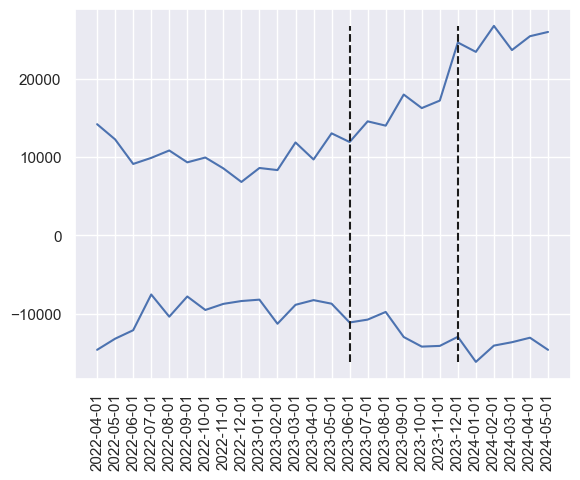

In [31]:
plt.plot(data2['month_dt'], data2['upper'], color = 'b')
plt.xticks(rotation =90)
plt.plot(data2['month_dt'], data2['lower'], color = 'b')
plt.vlines(x = ['2023-12-01', t_treatment], ymin = data2['lower'].min(), ymax = data2['upper'].max(), colors='k', linestyles='--')
